# Formulate Full-Space and Reduced-Space Neural Networks in OMLT

### In this example we show how different neural networks can be formulated using Pyomo and OMLT.

In [17]:
import pyomo.environ as pyo
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt

import pyomo.environ as pyo
from tensorflow.keras.models import load_model

In [56]:
from omlt.neuralnet import NetworkDefinition
from omlt.io import keras_reader
import omlt

## Import Neural Network from saved Keras file

For demonstration purposes, we trained a neural network that learned a simple sin wave function given by:
$sin(\omega*x) + x^2$ on the interval $x \in [-2,2]$

In [27]:
#load the original training data
df = pd.read_csv("keras_model_sin_wave/sinwave_dataset.csv")

### The training data captures the function of interest and is plotted below

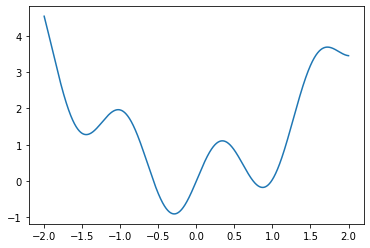

In [33]:
x = df["x"]
y = df["y"]
plt.plot(x,y)

### Importantly, we use scaling information and training to formulate neural networks in OMLT

In [32]:
#load scaling and bounds
with open("keras_model_sin_wave/scale.json", 'r') as f:
    scales = json.load(f)
    f.close()

with open("keras_model_sin_wave/bounds.json", 'r') as f:
    bounds = json.load(f)
    f.close()
print("scaling data: ",scales)
print("training bounds: ",bounds)

scaling data:  {'mean': {'x': -5.10702591327572e-18, 'y': 1.3336000266693333}, 'std': {'x': 1.1548737593388, 'y': 1.3784554666712947}}
training bounds:  {'min': {'x': -2.0, 'y': -0.9086219566495785}, 'max': {'x': 2.0, 'y': 4.5440211108893696}}


### We load the neural network from Keras and show a decent fit to our simple sin curve

In [39]:
#Load the neural network
keras_nn = load_model("keras_model_sin_wave")

# Scale inputs
scaled_x = (x - scales['mean']['x'])/ (scales['std']["x"])

# Get predictions and convert to dataframe
y_predict_scaled = keras_nn.predict(x=scaled_x)
y_predict = y_predict_scaled*(scales['std']["y"]) + scales['mean']["y"]

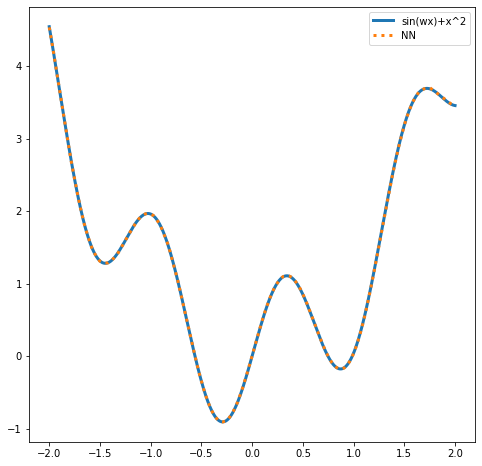

In [54]:
fig,ax = plt.subplots(1,figsize = (8,8))
ax.plot(x,y,linewidth = 3.0,label = "sin(wx)+x^2")
ax.plot(x,y_predict,linewidth = 3.0,linestyle="dotted",label = "NN")
plt.legend()

## Formulating the OMLT Model

In [ ]:
model = pyo.ConcreteModel()
model.nn = OmltBlock()

#the neural net contains one input and one output
model.input = pyo.Var()
model.output = pyo.Var()

In [62]:
scale_x = [scales['mean']['x'],scales['std']['x']]
scale_y = [scales['mean']['y'],scales['std']['y']]
scaler = omlt.scaling.OffsetScaling(offset_inputs=[scale_x[0]],
                    factor_inputs=[scale_x[1]],
                    offset_outputs=[scale_y[0]],
                    factor_outputs=[scale_y[1]])
input_bounds=[(bounds['min']['x']),bounds['max']['x']]

print(scaler)
print(input_bounds)

[-2.0, 2.0]


In [64]:
net = omlt.io.load_keras_sequential(keras_nn,scaler,input_bounds)

TypeError: __init__() got an unexpected keyword argument 'n_inputs'

## Multiple neural network formulations are possible. These include: 
FullSpaceContinuousFormulation, ReducedSpaceContinuousFormulation, ReLUBigMFormulation, ReLUComplementarityFormulation

## FullSpaceContinuousFormulation 

In [ ]:
#hides the intermediate variables from the optimizer
formulation = ReducedSpaceContinuousFormulation(net)

#build the formulation on the OMLT block
model.nn.build_formulation(formulation, input_vars=[model.input], output_vars=[model.output])

#query inputs and outputs, as well as scaled inputs and outputs
model.nn.inputs_list
model.nn.outputs_list
model.nn.scaled_inputs_list
model.nn.scaled_outputs_list

### Solving the Pyomo Model

In [ ]:
model.obj = pyo.Objective(expr=(model.output - 0.5)**2)
status = pyo.SolverFactory('ipopt').solve(model, tee=False)
print(pyo.value(model.input))
print(pyo.value(model.output))

In [ ]:
formulation = FullSpaceContinuousFormulation(net)

In [ ]:
formulation = ReLUBigMFormulation(net)

In [65]:
formulation = ReLUComplementarityFormulation(net)

NameError: name 'ReLUComplementarityFormulation' is not defined